<a href="https://colab.research.google.com/github/CompPsychology/psych290_colab_public/blob/main/notebooks/week-09/W9_Tutorial_15_LLM_annotation_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W9 Tutorial 15 -- LLM Sentiment Analysis (DB: dla_tutorial) (2025-05)

(c) Samuel Campione, Johannes Eichstaedt & the World Well-Being Project, 2025.

✋🏻✋🏻 NOTE - You need to create a copy of this notebook before you work through it. Click on "Save a copy in Drive" option in the File menu, and safe it to your Google Drive.

✉️🐞 If you find a bug/something doesn't work, please slack us a screenshot, or email johannes.courses@gmail.com.

This tutorial walks you through the basics of working with a large language model (LLM) to annotate text data.

LLMs analyze language data and gain nuanced, context-aware understanding. By providing a clear set of instructions to the model, you can define a feature (like sentiment or some psychological construct) and the LLM can determine if the text contains it.

🤩 We'll be usign OpenAI's API which allows access to the latest GPT models. You could also do this with Gemini, Claude, DeepSeek, etc.!

## 1) Setting up Colab with DLATK and SQLite


### a) Install DLATK

In [ ]:
# installing DLATK and necessary packages
!git clone -b psych290 https://github.com/dlatk/dlatk.git
!pip install -r dlatk/install/requirements.txt
!pip install dlatk/
!pip install wordcloud langid jupysql

### b) Mount Google Drive and copy databases

💡 **Uploading your own data**: if you're working with new data (CSVs), see how to upload them [with DLATK in Tutorial 5B](https://github.com/CompPsychology/psych290_colab_public/blob/main/notebooks/week-03/W3_Tutorial_05B_mini_tutorial_saving_SQLite_in_GoogleDrive_(dla_tutorial).ipynb) or [with R in Tutorial 7](https://github.com/CompPsychology/psych290_colab_public/blob/main/notebooks/week-05/W5_Tutorial_07_R_dataImport_metaTablePlots_(csv).ipynb)!

For now, `dla_tutorial` should be saved in your Google Drive already 😎

In [ ]:
database = "dla_tutorial"

In [ ]:
# Mount Google Drive & copy to Colab

# connects & mounts your Google Drive to this colab space
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# this copies dlatk_lexica.db from your Google Drive to Colab
!cp -f "/content/drive/MyDrive/sqlite_databases/dlatk_lexica.db" "sqlite_data"

# this copies {database}.db from your Google Drive to Colab
!cp -f "/content/drive/MyDrive/sqlite_databases/{database}.db" "sqlite_data"

In [ ]:
### ALTERNATIVE: this creates the database from scratch

database = "dla_tutorial"
!git clone https://github.com/CompPsychology/psych290_data.git

# load the required package -- similar to library() function in R
import os
from dlatk.tools.importmethods import csvToSQLite

# complete path to the database in this colab
database_path = os.path.join("sqlite_data", database)

msgs = "psych290_data/dla_tutorial/msgs.csv"
csvToSQLite(msgs, database_path, "msgs")

outcomes = "psych290_data/dla_tutorial/blog_outcomes.csv"
csvToSQLite(outcomes, database_path, "outcomes")

### c) Setup database connection

In [ ]:
# loads the %%sql extension
%load_ext sql

# connects the extension to the database - mounts both databases as engines
from sqlalchemy import create_engine
tutorial_db_engine = create_engine(f"sqlite:///sqlite_data/{database}.db?charset=utf8mb4")
dlatk_lexica_engine = create_engine(f"sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4")

# attaches the dlatk_lexica.db so tutorial_db_engine can query both databases
from IPython import get_ipython
from sqlalchemy import event

# auto‑attach the lexica db whenever tutorial_db_engine connects
@event.listens_for(tutorial_db_engine, "connect")
def _attach_lexica(dbapi_conn, connection_record):
    dbapi_conn.execute("ATTACH DATABASE 'sqlite_data/dlatk_lexica.db' AS dlatk_lexica;")

%sql tutorial_db_engine

#set the output limit to 50
%config SqlMagic.displaylimit = 50

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


### d) If you have a **"database lock"** problem

If you face a "database locked" issue:
  1. **restart the session** (Runtime ==> Restart Session)
  2. run this cell to get set back up!

In [ ]:
database = "dla_tutorial" # or whichever database you are working with!! (e.g., 'svitlana', 'dla_tutorial', etc)

%reload_ext sql

from sqlalchemy import create_engine
tutorial_db_engine = create_engine(f"sqlite:///sqlite_data/{database}.db?charset=utf8mb4")
dlatk_lexica_engine = create_engine(f"sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4")

# set the output limit to 50
%config SqlMagic.displaylimit = 50

from IPython import get_ipython
from sqlalchemy import event

# auto‑attach the lexica db whenever tutorial_db_engine connects
@event.listens_for(tutorial_db_engine, "connect")
def _attach_lexica(dbapi_conn, connection_record):
    dbapi_conn.execute("ATTACH DATABASE 'sqlite_data/dlatk_lexica.db' AS dlatk_lexica;")

%sql tutorial_db_engine

## 2) Set up OpenAI connection

💡 To annotate our data, we'll use the OpenAI's API (an API is basically how computers talk to each other). These APIs require us to make use of an API "secret key" to connect. You can obtain this key from your user profile once you sign-up for an OpenAI platform account here - https://platform.openai.com.

☝🏻 If you are paying for ChatGPT, you still have to set up a new platform key with a credit card -- these things are different!

🚨 **FYI**: Copy the secret key, store it securely (you won’t be able to see it again!), and do not share it online.

Let's set up the connection to OpenAI so we can ask it to generate text based on what we send it. Don't forget to set **`OPEN_API_KEY=''`** to your OpenAI secret key.

In [ ]:
from openai import OpenAI

# Assign your OpenAI API key here!
OPENAI_API_KEY = ""

# Set up connection to OpenAI
client = OpenAI(api_key=OPENAI_API_KEY)

## 3) Annotate using GPT

First things first, we want to test this on a subset of the `msgs` table from `dla_tutorial`. We'll get a random sample of 100 messages from there.

In [ ]:
%%sql

DROP TABLE IF EXISTS msgs_anno;

CREATE TABLE msgs_anno AS SELECT * FROM msgs ORDER BY RANDOM() LIMIT 100;

Running query in 'sqlite:///sqlite_data/dla_tutorial.db?charset=utf8mb4'

++
||
++
++

### a) Define a system prompt

We're going to use GPT as a sentiment annotator. For that, we need to provide clear instructions in the form of a *system prompt*. This tells the model exactly what to do when we send it a message.

🤓 **Note**: There are several methods for LLM prompting: Zero-shot, Few-shot, Chain-of-thought, etc.. We'll use few-shot learning (giving examples in the prompt of input text and output of how it should be annotated/classified). See more resources on prompt engineering here [OpenAI Prompt Engineering](https://platform.openai.com/docs/guides/text?api-mode=chat)

**Option 1: sentiment as continuous score**

In [ ]:
# return values from -1 to 1
system_prompt = """
You are a sentiment scoring model.

Instructions:
- Read the input message.
- Rate its sentiment on a scale from -1 to 1:
  - -1 means extremely negative
  - 0 means neutral
  - 1 means extremely positive
- Use decimal values when appropriate to reflect nuance.

Formatting Rules:
- Respond with a single numeric value only (e.g., -0.8, 0.0, 0.7).
- Do not include any text, punctuation, units, or explanation.

Examples:
Message: Been feeling a bit depressed and empty
Response: -0.9

Message: Played SimCity 4 today
Response: 0.0

Message: life's awesome when yur having fun!!!
Response: 0.95

Only respond with a single number between -1 and 1
"""


**Option 2: sentiment class** (uncomment if you want to use)

In [ ]:
# # return 'positive' or 'negative'
# system_prompt = """
# You are a sentiment classification model.

# Instructions:
# - Read the input message.
# - Return its sentiment as either 'positive' or 'negative'.

# Formatting Rules:
# - Output must be exactly one word: either 'positive' or 'negative'.
# - Do not include punctuation, explanation, or any additional text.
# - Do not return 'neutral' or any other label.

# Examples:
# Message: I had a horrible day
# Response: negative

# Message: I love games!
# Response: positive

# Only respond with: positive OR negative
# """

### b) Run the GPT annotation

We need to define a Python function to actually send each message to the LLM and receive its response.

In [ ]:
# Function to send the GPT query and get back the response

def get_gpt_response(msg, system_prompt):
    message = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": msg}]


    response = client.chat.completions.create(
        model="gpt-3.5-turbo", # this determines which GPT model you want to use!
        messages=message)

    response = response.choices[0].message.content
    return response

Now, let's run the annotation on the `msgs_anno` SQL table

We save the annotated dataframe output to a new SQL table called `msgs_anno_gpt`.

⏰ On our end, this seemed somewhat slow. Keys also come at different tiers -- your lab may have a higher (faster) key than you do if you just made it...

In [ ]:
# A Python data manipulation package
import pandas as pd

# Get the table into Python from SQL
df = pd.read_sql("SELECT * FROM msgs_anno;", con=tutorial_db_engine)

# Get a sentiment label by applying the get_gpt_response function to each message
sentiments = []
for i, msg in enumerate(df["message"]):
    sentiment = get_gpt_response(msg, system_prompt) # actual LLM annotation happens here!
    sentiments.append(sentiment)
    if (i + 1) % 10 == 0:
        print(f"{i + 1} messages processed")

df["gpt_sentiment"] = sentiments
df["gpt_sentiment"] = df["gpt_sentiment"].astype('float')

# Save newly annotated data to SQLite table called msgs_anno_gpt
df.to_sql('msgs_anno_gpt', con=tutorial_db_engine)

In [ ]:
# Look at the top few messages and gpt annotations
df.head()

,message_id,user_id,date,created_time,message,gpt_sentiment
0,16749,4198810,"11,August,2004",2004-08-11 00:00:00,Ever wonder why people aspire to owning ger...,-0.80
1,10824,832265,"02,August,2004",2004-08-02 00:00:00,The army urlLink dismissed nine of its l...,-0.80
2,20923,3665752,"04,August,2004",2004-08-04 00:00:00,The internet should not tolerate this kind ...,-0.80
3,29800,1011311,"29,December,2002",2002-12-29 00:00:00,"So, I just got back from Stratton. It was...",-0.85
4,13561,3343256,"22,June,2004",2004-06-22 00:00:00,Generally when we think of the environment ...,0.80


Now you have LLM annotated messages! 🥳

### c) Descriptives on the LLM annotations

In [ ]:
# Option 1: continuous sentiment
df["gpt_sentiment"].astype('float').describe()

# Option 2: sentiment classes
# df["gpt_sentiment"].value_counts()

,gpt_sentiment
count,100.000000
mean,-0.084000
std,0.600752
min,-0.950000
25%,-0.700000
50%,0.050000
75%,0.400000
max,0.950000


Let's quickly look at the distribution of sentiments with Python:

<Axes: >

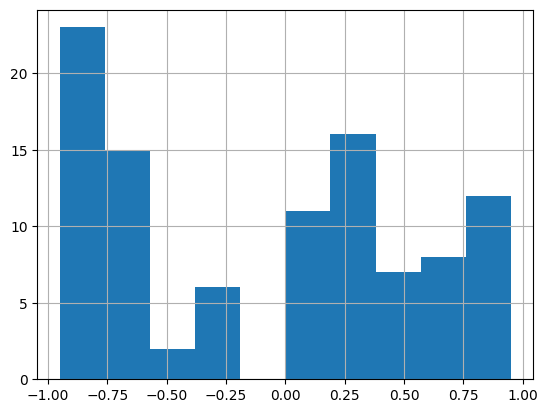

In [ ]:
df["gpt_sentiment"].astype("float").hist()

## 4) Optional: Extract NRC sentiment and correlate -- for comparison

Let's compare how the LLM annotation does to NRC (which is a sentiment dictionary).

### a) Extract NRC sentiment

First step, let's extract 1-grams.

In [ ]:
database = "dla_tutorial"
msgs_table = "msgs_anno"
correl_field = "message_id"

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field {correl_field} \
    --add_ngrams -n 1

Now, let's actually extract sentiment features using NRC (table `nrc` in the `dlatk_lexica` database).

In [ ]:
database = "dla_tutorial"
msgs_table = "msgs_anno"
correl_field = "message_id"

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field {correl_field} \
    --add_lex_table -l nrc \
    --weighted_lexicon

### b) Correlate NRC and GPT sentiment

Since we have both sets of features for the same messages, let's see how correlated they are using Pearson's r.

In [ ]:
# Get the newly extracted table into Python
# like dbGetQuery() in R!
df_nrc = pd.read_sql("SELECT * FROM 'feat$cat_nrc_w$msgs_anno$message_id$1gra' WHERE feat = 'SENT'", con=tutorial_db_engine)

We need to join the dataframe with the `gpt_sentiment` and with nrc sentiment values.

In [ ]:
# Now create a merged dataframe to compare the two
df_merged = df_nrc.merge(df, left_on="group_id", right_on="message_id")

# Rename NRC group_norm to nrc_sentiment for understandability
df_merged = df_merged.rename(columns={'group_norm':'nrc_sentiment'})

👀 Finally, look at the correlation.

In [ ]:
# Now let's correlate them
correlation = df_merged['gpt_sentiment'].corr(df_merged['nrc_sentiment'])
print("Pearson correlation:", correlation)

Pearson correlation: 0.3815643470604168


Let's check the distribution of the NRC sentiment values.

<Axes: >

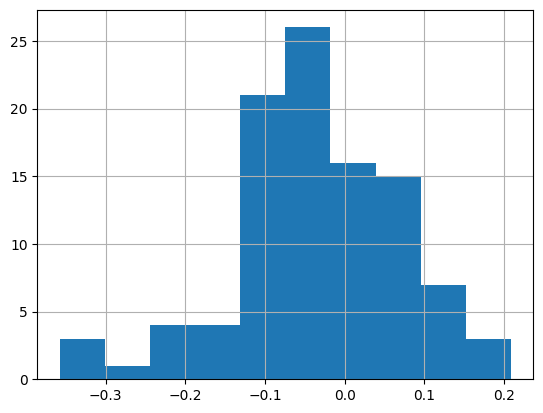

In [ ]:
df_merged["nrc_sentiment"].astype("float").hist()

😯 A very different distribution than GPT!

Quick scatter plot to confirm...

<Axes: xlabel='gpt_sentiment', ylabel='nrc_sentiment'>

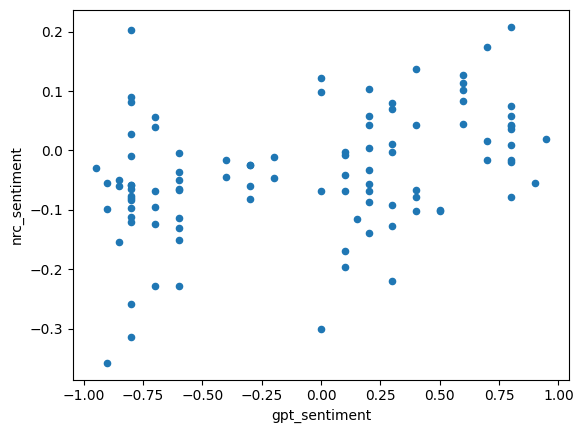

In [ ]:
df_merged.plot(kind="scatter", x='gpt_sentiment', y='nrc_sentiment')

so very different distributions lead to a low correlation.

So it correlates, but not very highly.

## ‼️ **Save your annotated data and/or database** ‼️

Let's save all this work into as a database file in your GDrive `sqlite_databases` folder!

In [ ]:
database = 'dla_tutorial'

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# copy the database file to your Drive
!cp -f "sqlite_data/{database}.db" "/content/drive/MyDrive/sqlite_databases/"

print(f"✅ Database '{database}.db' has been copied to your Google Drive.")

You can also just save the newly annotated directly to a CSV by using this:

In [ ]:
df.to_csv("msgs_anno_gpt.csv")